## Text Classification

# Notebook Content
## Text Classification
[Data Preparation](#Preparing-Data-for-Modeling)<br>
[Logistic Regression Classifier](#Logistic-Regression)<br>
[Support Vector Classifier](#1)<br>
[Gradient Boosting Classifier](#2)<br>
[Decision Tree](#3)<br>
[Random Forest Classifier](#4)<br>
[KNN Classifier](#5)<br>
[Gradient Descent](#6)<br>
[Stochastic Gradient Descent](#7)<br>
[XGBoost Classifier](#8)<br>

## Text Classification
The domain of analytics that addresses how computers understand text is called Natural Language Processing (NLP). NLP has multiple applications like sentiment analysis, chatbots, AI agents, social media analytics, as well as text classification. In this guide, you will learn how to build a supervised machine learning model on text data, using the popular statistical programming language, 'R'.

## Library

In [1]:
# install.packages("kernlab")
# install.packages("caret")
# install.packages("tm")
# install.packages("dplyr")
# install.packages("splitstackshape")
# install.packages("e1071")
# install.packages("SnowballC")
# install.packages("rattle")
# install.packages("gmodels")
# install.packages('randomForest')

<a class="list-group-item list-group-item-action" data-toggle="list" href="#Text-Classification" role="tab" aria-controls="profile">Go to top<span class="badge badge-primary badge-pill"></span></a>

## Data
The data we’ll be using in this guide comes from Kaggle, a machine learning competition website. This is a women's clothing e-commerce data, consisting of the reviews written by the customers. In this guide, we will take up the task of predicting whether the customer will recommend the product or not. In this guide, we are taking a sample of the original dataset. The sampled data contains 500 rows and three variables, as described below: 1. Clothing ID: This is the unique ID. 2. Review Text: Text containing reviews by the customer. 3. Recommended IND: Binary variable stating where the customer recommends the product ("1") or not ("0"). This is the target variable. Let us start by loading the required libraries and the data.

In [3]:
library(readr)
library(dplyr)
 
#Text mining packages
library(tm)
library(SnowballC)
options(warn=-1) #To supress waarning messages

#loading the data
t1 <- read.csv('dataset/Womens Clothing E-Commerce Reviews.csv')
glimpse(t1) 

Warning message:
"package 'readr' was built under R version 3.6.3"
Warning message:
"package 'SnowballC' was built under R version 3.6.3"


Rows: 23,486
Columns: 11
$ X                       <int> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1...
$ Clothing.ID             <int> 767, 1080, 1077, 1049, 847, 1080, 858, 858,...
$ Age                     <int> 33, 34, 60, 50, 47, 49, 39, 39, 24, 34, 53,...
$ Title                   <fct> "", "", "Some major design flaws", "My favo...
$ Review.Text             <fct> "Absolutely wonderful - silky and sexy and ...
$ Rating                  <int> 4, 5, 3, 5, 5, 2, 5, 4, 5, 5, 3, 5, 5, 5, 3...
$ Recommended.IND         <int> 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1...
$ Positive.Feedback.Count <int> 0, 4, 0, 0, 6, 4, 1, 4, 0, 0, 14, 2, 2, 0, ...
$ Division.Name           <fct> Initmates, General, General, General Petite...
$ Department.Name         <fct> Intimate, Dresses, Dresses, Bottoms, Tops, ...
$ Class.Name              <fct> Intimates, Dresses, Dresses, Pants, Blouses...


The above output shows that the data has other variables, but the important ones are the variables 'Review_Text', and 'Recommended_IND'.

## Preparing Data for Modeling
Since the text data is not in the traditional format of observations in rows, and variables in columns, we will have to perform certain text-specific steps. The list of such steps is discussed in the subsequent sections.

**Step 1 - Create the Text Corpus**<br>
The variable containing text needs to be converted to a corpus for preprocessing. A corpus is a collection of documents. The first line of code below performs this task. The second line prints the content of the first corpus, while the third line prints the corresponding recommendation score.

In [4]:
corpuss = Corpus(VectorSource(t1$Review.Text))
corpuss[[1]][1]
t1$Recommended.IND[1]

$content
[1] "Absolutely wonderful - silky and sexy and comfortable"

[1] 1

Looking at the review text, it is obvious that the customer not happy with the product, and hence gave the recommendation score of one.

**Step 2 - Conversion to Lowercase**<br>
The model needs to treat Words like 'soft' and 'Soft' as same. Hence, all the words are converted to lowercase with the lines of code below.

In [5]:
corpuss = tm_map(corpuss, PlainTextDocument)
corpuss = tm_map(corpuss, tolower)
corpuss[[1]][1] 

$content
[1] "absolutely wonderful - silky and sexy and comfortable"

**Step 3 - Removing Punctuation**<br>
The idea here is to remove everything that isn't a standard number or letter.

In [6]:
corpuss = tm_map(corpuss, removePunctuation)
corpuss[[1]][1]

$content
[1] "absolutely wonderful  silky and sexy and comfortable"

**Step 4 - Removing Stopwords**<br>
Stopwords are unhelpful words like 'i', 'is', 'at', 'me', 'our'. These are not helpful because the frequency of such stopwords is high in the corpus, but they don't help in differentiating the target classes. The removal of Stopwords is therefore important.

The line of code below uses the tm_map function on the 'corpus' and removes stopwords, as well as the word 'cloth'. The word 'cloth' is removed because this dataset is on clothing review, so this word will not add any predictive power to the model.

In [7]:
corpuss = tm_map(corpuss, stemDocument)
corpuss[[1]][1]

$content
[1] "absolut wonder silki and sexi and comfort"

**Step 5 - Stemming**<br>
The idea behind stemming is to reduce the number of inflectional forms of words appearing in the text. For example, words such as "argue", "argued", "arguing", "argues" are reduced to their common stem "argu". This helps in decreasing the size of the vocabulary space. The lines of code below perform the stemming on the corpus.

**Create Document Term Matrix**<br>
The most commonly used text preprocessing steps are complete. Now we are ready to extract the word frequencies, which will be used as features in our prediction problem. The line of code below uses the function called DocumentTermMatrix from the tm package and generates a matrix. The rows in the matrix correspond to the documents, in our case reviews, and the columns correspond to words in those reviews. The values in the matrix are the frequency of the word across the document.

In [8]:
frequencies = DocumentTermMatrix(corpuss)

The above command results in a matrix that contains zeroes in many of the cells, a problem called sparsity. It is advisable to remove such words that have a lot of zeroes across the documents. The following lines of code perform this task.

In [9]:
sparse = removeSparseTerms(frequencies, 0.995)

The final data preparation step is to convert the matrix into a data frame, a format widely used in 'R' for predictive modeling. The first line of code below converts the matrix into dataframe, called 'tSparse'. The second line makes all the variable names R-friendly, while the third line of code adds the dependent variable to the data set.

In [10]:
tSparse = as.data.frame(as.matrix(sparse))
colnames(tSparse) = make.names(colnames(tSparse))
tSparse$recommended_id = t1$Recommended.IND

Now we are ready for building the predictive model. But before that, it is always a good idea to set the baseline accuracy of the model. The baseline accuracy, in the case of a classification problem, is the proportion of the majority label in the target variable. The line of code below prints the proportion of the labels in the target variable, 'recommended_id'.

In [11]:
prop.table(table(tSparse$recommended_id))


        0         1 
0.1776377 0.8223623 

The above output shows that 82.23 percent of the reviews are from customers who recommended the product. This becomes the baseline accuracy for predictive modeling.

<a class="list-group-item list-group-item-action" data-toggle="list" href="#Text-Classification" role="tab" aria-controls="profile">Go to top<span class="badge badge-primary badge-pill"></span></a>

## Creating Training and Test Data for Machine Learning
For evaluating how the predictive model is performing, we will divide the data into training and test data. The first line of code below loads the caTools package, which will be used for creating the training and test data. The second line sets the 'random seed' so that the results are reproducible.
The third line creates the data partition in the manner that it keeps 70% of the data for training the model. The fourth and fifth lines of code create the training ('trainSparse') and testing ('testSparse') dataset.

In [12]:
library(caTools)
set.seed(100)
split = sample.split(tSparse$recommended_id, SplitRatio = 0.7)
trainSparse = subset(tSparse, split==TRUE)
testSparse = subset(tSparse, split==FALSE)

You can train you model on all the rows of the dataset, we have subsetted here to reduce the training time.

In [13]:
trainSparse = trainSparse[1:1000,]
testSparse = testSparse[1:400,]

In [14]:
set.seed(100)
trainSparse$recommended_id = as.factor(trainSparse$recommended_id)
testSparse$recommended_id = as.factor(testSparse$recommended_id)

<a class="list-group-item list-group-item-action" data-toggle="list" href="#Text-Classification" role="tab" aria-controls="profile">Go to top<span class="badge badge-primary badge-pill"></span></a>

## Logistic Regression
In this algorithm, the probabilities describing the possible outcomes of a single trial are modelled using a logistic function.
It is used to model the probability of a certain class or event existing 
such as pass/fail, win/lose, alive/dead or healthy/sick.

In [15]:
glmnet_classifier = glm(recommended_id ~ ., data=trainSparse,
    family = 'binomial')

In [16]:
predictLR = predict(glmnet_classifier, newdata=testSparse)
predictions = ifelse(predictLR >.5, 1, 0)
table(testSparse$recommended_id, predictions)

   predictions
      0   1
  0  44  29
  1 111 216

In [17]:
#confusion matrix
library(e1071)
library(caret)
confusionMatrix(as.factor(predictions), testSparse$recommended_id)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  44 111
         1  29 216
                                         
               Accuracy : 0.65           
                 95% CI : (0.601, 0.6967)
    No Information Rate : 0.8175         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.1833         
                                         
 Mcnemar's Test P-Value : 7.608e-12      
                                         
            Sensitivity : 0.6027         
            Specificity : 0.6606         
         Pos Pred Value : 0.2839         
         Neg Pred Value : 0.8816         
             Prevalence : 0.1825         
         Detection Rate : 0.1100         
   Detection Prevalence : 0.3875         
      Balanced Accuracy : 0.6316         
                                         
       'Positive' Class : 0              
                                         

<a class="list-group-item list-group-item-action" data-toggle="list" href="#Text-Classification" role="tab" aria-controls="profile">Go to top<span class="badge badge-primary badge-pill"></span></a>

<a id="1"></a>

## Support Vector Classifier
The support vector machine is a classifier that represents the training data as points in space separated into categories by a gap as wide as possible. 
New points are then added to space by predicting which category they fall into and which space they will belong to.

More often text classification use cases will have linearly separable data and LinearSVC is apt for such scenarios

In [18]:
#Load Library
library(e1071)

# Fitting the model
model_svm = svm(recommended_id ~ ., data=trainSparse)

# Making 
predictions = predict(model_svm, newdata=testSparse, method="C-classification", kernal="radial", 
          gamma=0.1, cost=10)

In [19]:
predictions = ifelse(predictLR >.5, 1, 0)
table(predictions, testSparse$recommended_id)

           
predictions   0   1
          0  44 111
          1  29 216

In [20]:
#confusion matrix
library(e1071)
library(caret)
confusionMatrix(as.factor(predictions), testSparse$recommended_id)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  44 111
         1  29 216
                                         
               Accuracy : 0.65           
                 95% CI : (0.601, 0.6967)
    No Information Rate : 0.8175         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.1833         
                                         
 Mcnemar's Test P-Value : 7.608e-12      
                                         
            Sensitivity : 0.6027         
            Specificity : 0.6606         
         Pos Pred Value : 0.2839         
         Neg Pred Value : 0.8816         
             Prevalence : 0.1825         
         Detection Rate : 0.1100         
   Detection Prevalence : 0.3875         
      Balanced Accuracy : 0.6316         
                                         
       'Positive' Class : 0              
                                         

<a class="list-group-item list-group-item-action" data-toggle="list" href="#Text-Classification" role="tab" aria-controls="profile">Go to top<span class="badge badge-primary badge-pill"></span></a>

<a id="2"></a>

## Gradient Boosting Classifier
GB builds an additive model in a forward stage-wise fashion
It allows for the optimization of arbitrary differentiable loss functions. 
Binary classification is a special case where only a single regression tree is induced.

Loaded gbm 2.1.5



,var,rel.inf
,<fct>,<dbl>
was,was,25.4493493
return,return,16.9791012
back,back,11.1731467
disappoint,disappoint,10.9386761
unfortun,unfortun,6.3792747
with,with,5.1806575
wide,wide,3.2389267
size,size,2.0544616
thought,thought,1.8285234


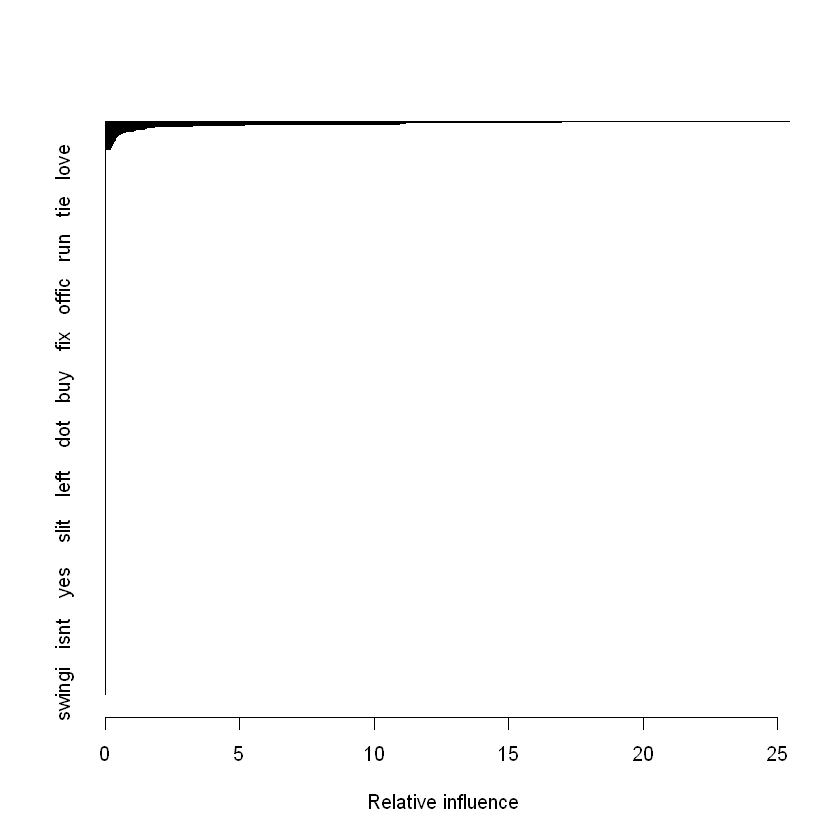

In [21]:
# Load the required libraries
library(gbm)

# Fit the model
model_gbm = gbm(recommended_id ~ ., data=trainSparse,  distribution = "gaussian",n.trees = 50,
                  shrinkage = 0.01, interaction.depth = 4)

#variance importance plt
summary(model_gbm)

In [22]:
#Generating a Prediction matrix for each Tree
predictions <- predict(model_gbm, testSparse, n.trees = 50, type="response")

In [23]:
predictions = ifelse(predictions >1.78, 1, 0)
table(predictions, testSparse$recommended_id)

           
predictions   0   1
          0  48  51
          1  25 276

In [24]:
#confusion matrix
library(e1071)
library(caret)
confusionMatrix(as.factor(predictions), testSparse$recommended_id)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  48  51
         1  25 276
                                          
               Accuracy : 0.81            
                 95% CI : (0.7681, 0.8473)
    No Information Rate : 0.8175          
    P-Value [Acc > NIR] : 0.678628        
                                          
                  Kappa : 0.4406          
                                          
 Mcnemar's Test P-Value : 0.004135        
                                          
            Sensitivity : 0.6575          
            Specificity : 0.8440          
         Pos Pred Value : 0.4848          
         Neg Pred Value : 0.9169          
             Prevalence : 0.1825          
         Detection Rate : 0.1200          
   Detection Prevalence : 0.2475          
      Balanced Accuracy : 0.7508          
                                          
       'Positive' Class : 0               
                              

<a class="list-group-item list-group-item-action" data-toggle="list" href="#Text-Classification" role="tab" aria-controls="profile">Go to top<span class="badge badge-primary badge-pill"></span></a>

<a id="3"></a>

## Decision Tree
The decision tree algorithm builds the classification model in the form of a tree structure. 
It utilizes the if-then rules which are equally exhaustive and mutually exclusive in classification.

We can use decision tree when there are missing values in the data and when pre processing time is to be reduced as it does not require pre processing

In [25]:
#Loading libraries
library(rpart,quietly = TRUE)
#library(caret,quietly = TRUE)
library(rpart.plot,quietly = TRUE)
library(rattle)

#building the classification tree with rpart
library(rpart)
model_dt <- rpart(recommended_id ~ ., data=trainSparse,
                method = "class")

Loading required package: tibble

Loading required package: bitops

Rattle: A free graphical interface for data science with R.
Version 5.4.0 Copyright (c) 2006-2020 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.



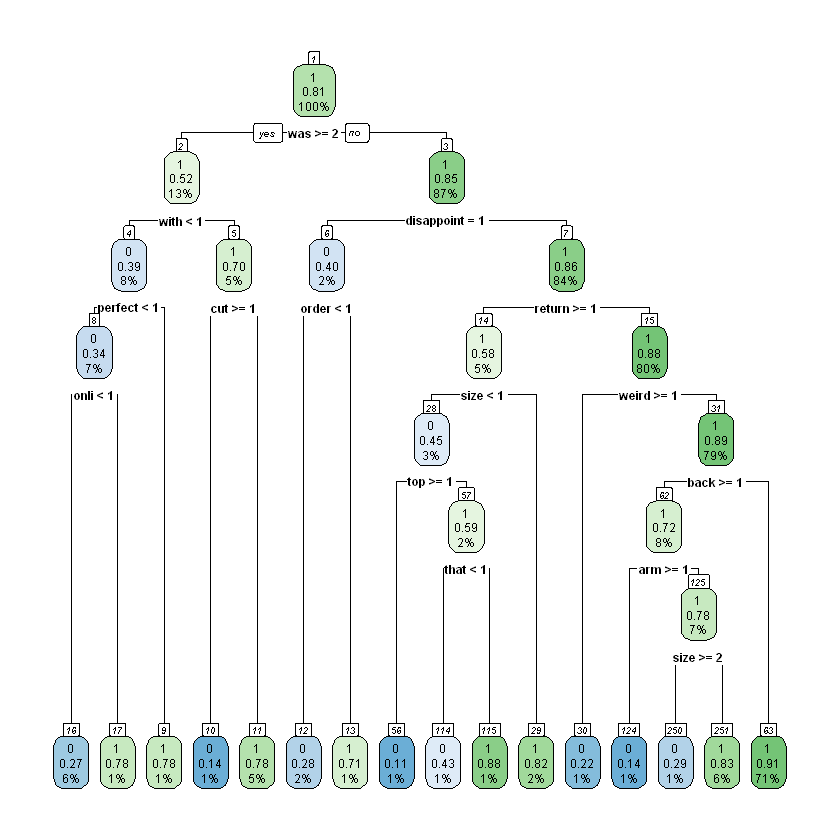

In [26]:
# Visualize the decision tree with rpart.plot
library(rpart.plot)
rpart.plot(model_dt, nn=TRUE)

In [27]:
#Testing the model
predictions <- predict(model_dt, testSparse, type="class")

In [28]:
table(predictions, testSparse$recommended_id)

           
predictions   0   1
          0  30  23
          1  43 304

In [29]:
#confusion matrix
library(e1071)
library(caret)
confusionMatrix(as.factor(predictions), testSparse$recommended_id)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  30  23
         1  43 304
                                        
               Accuracy : 0.835         
                 95% CI : (0.7949, 0.87)
    No Information Rate : 0.8175        
    P-Value [Acc > NIR] : 0.20117       
                                        
                  Kappa : 0.3812        
                                        
 Mcnemar's Test P-Value : 0.01935       
                                        
            Sensitivity : 0.4110        
            Specificity : 0.9297        
         Pos Pred Value : 0.5660        
         Neg Pred Value : 0.8761        
             Prevalence : 0.1825        
         Detection Rate : 0.0750        
   Detection Prevalence : 0.1325        
      Balanced Accuracy : 0.6703        
                                        
       'Positive' Class : 0             
                                        

<a class="list-group-item list-group-item-action" data-toggle="list" href="#Text-Classification" role="tab" aria-controls="profile">Go to top<span class="badge badge-primary badge-pill"></span></a>

<a id="4"></a>

## Random Forest Classifier
Random forest are an ensemble learning method.
It operates by constructing a multitude of decision trees at training time and outputs the class that is the mode of the classes of the individual trees.
A random forest is a meta-estimator that fits a number of trees on various subsamples of data sets and then uses an average to improve the accuracy in the model’s predictive nature.
The sub-sample size is always the same as that of the original input size but the samples are often drawn with replacements.

We should use this algorithm when we need high accuracy while working with large datasets with higher dimensions. We can also use it if there are missing values in the dataset. We should not use it if we have less time for modeling or if large computational costs and memory space are a constrain.

In [30]:
library(randomForest)
options(warn=-1) #To supress waarning messages

RF_model = randomForest(recommended_id ~ ., data=trainSparse)
predictRF = predict(RF_model, newdata=testSparse)
table(testSparse$recommended_id, predictRF)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:rattle':

    importance


The following object is masked from 'package:dplyr':

    combine


The following object is masked from 'package:ggplot2':

    margin




   predictRF
      0   1
  0  11  62
  1   0 327

<a class="list-group-item list-group-item-action" data-toggle="list" href="#Text-Classification" role="tab" aria-controls="profile">Go to top<span class="badge badge-primary badge-pill"></span></a>

<a id="5"></a>

## KNN Classifier
It is a lazy learning algorithm that stores all instances corresponding to training data in n-dimensional space
To label a new point, it looks at the labeled points closest to that new point also known as its nearest neighbors

We should use KNN when the dataset is small and speed is a priority (real-time)

In [31]:
library(class)
predictions <- knn(train = trainSparse, test = testSparse, cl = trainSparse$recommended_id, k=10)

In [32]:
library(gmodels)
CrossTable(x = testSparse$recommended_id, y = predictions, prop.chisq=FALSE )


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  400 

 
                          | predictions 
testSparse$recommended_id |         0 |         1 | Row Total | 
--------------------------|-----------|-----------|-----------|
                        0 |        16 |        57 |        73 | 
                          |     0.219 |     0.781 |     0.182 | 
                          |     0.696 |     0.151 |           | 
                          |     0.040 |     0.142 |           | 
--------------------------|-----------|-----------|-----------|
                        1 |         7 |       320 |       327 | 
                          |     0.021 |     0.979 |     0.818 | 
                          |     0.304 |     0.849 |           | 
                          |     0.018 |     0.800 |           | 
-----------------

<a class="list-group-item list-group-item-action" data-toggle="list" href="#Text-Classification" role="tab" aria-controls="profile">Go to top<span class="badge badge-primary badge-pill"></span></a>

<a id="6"></a>

## Gradient Descent
Gradient descent is a first-order iterative optimization algorithm for finding a local minimum of a differentiable function.

In [33]:
# Loading required libraries
library(gradDescent)
# data = read.csv("pima-indians-diabetes.csv")
#winedata is scaled and then split
featureScalingResult <- varianceScaling(tSparse)
data = tSparse[1:1000,]
splitedDataset <- splitData(data)

# # Fit the train from splitted dataset data to GD model
model <- GD(splitedDataset$dataTrain)


Attaching package: 'gradDescent'


The following object is masked from 'package:caret':

    RMSE




In [34]:
print(model)

         [,1]     [,2]     [,3]     [,4]     [,5]      [,6]     [,7]     [,8]
[1,] 1104.043 50.83314 3011.386 164.8758 20.44298 0.9135144 30.80802 37.50258
         [,9]    [,10]    [,11]    [,12]    [,13]    [,14]    [,15]    [,16]
[1,] 139.7761 81.95206 92.30288 685.8664 57.40612 30.76642 2.110403 492.1616
        [,17]    [,18]    [,19]   [,20]    [,21]   [,22]    [,23]    [,24]
[1,] 52.42501 395.7703 67.74398 149.628 232.4159 538.979 23.36495 129.1613
        [,25]    [,26]    [,27]    [,28]    [,29]    [,30]    [,31]    [,32]
[1,] 274.2111 201.1285 123.2423 32.42281 147.9792 5299.139 1463.896 105.8012
        [,33]    [,34]   [,35]    [,36]    [,37]    [,38]    [,39]    [,40]
[1,] 2.593996 37.71189 352.128 102.0485 1048.341 24.14679 95.54462 73.61231
        [,41]    [,42]    [,43]    [,44]    [,45]    [,46]    [,47]    [,48]
[1,] 22.14137 662.1039 11.79398 767.5894 57.93305 185.2428 10.65327 53.31942
        [,49]    [,50]    [,51]    [,52]    [,53]    [,54]    [,55]    [,56]
[1,

In [35]:
# Test data input
dataTestInput <- (splitedDataset$dataTest)[,1:ncol(splitedDataset$dataTest)-1]

# Predict using linear model
predictions <- prediction(model, dataTestInput)
# predictions

<a class="list-group-item list-group-item-action" data-toggle="list" href="#Text-Classification" role="tab" aria-controls="profile">Go to top<span class="badge badge-primary badge-pill"></span></a>

<a id="7"></a>

## Stochastic Gradient Descent
SGD has been successfully applied to large-scale and sparse machine learning problems often encountered in text classification and natural language processing. 
Given that the data is sparse, the classifiers in this module easily scale to problems with more than 10^5 training examples and more than 10^5 features.

In [36]:
# Fitting the model
SGDmodel <- SGD(splitedDataset$dataTrain)

#show result
print(SGDmodel)

         [,1]      [,2]      [,3]      [,4]       [,5]      [,6]      [,7]
[1,] 23.60562 0.3570986 -67.58038 -0.852198 0.03072518 0.8345339 0.9337756
          [,8]     [,9]     [,10]    [,11]    [,12]      [,13]    [,14]
[1,] -9.687577 5.757197 0.5544197 2.434515 218.7185 0.02718541 2.821232
         [,15]    [,16]     [,17]    [,18]     [,19]     [,20]     [,21]
[1,] 0.1708038 95.77304 0.5149022 108.2886 -9.624174 -9.302528 0.4614279
         [,22]      [,23]     [,24]    [,25]    [,26]    [,27]     [,28]
[1,] -122.7846 0.08188764 0.4605931 39.41364 37.43043 44.64199 0.8321347
        [,29]   [,30]    [,31]    [,32]     [,33]     [,34]   [,35]     [,36]
[1,] 39.70286 357.437 -31.7594 56.69234 0.1221462 0.8760759 3.77568 0.7951142
        [,37]     [,38]     [,39]     [,40]     [,41]    [,42]        [,43]
[1,] 129.1638 0.4764346 0.9601035 -54.24243 0.3773622 8.425283 0.0002425576
         [,44]     [,45]    [,46]    [,47]     [,48]     [,49]     [,50]
[1,] -76.49155 -9.050672 54.16413

In [37]:
# Test data input
dataTestInput <- (splitedDataset$dataTest)[,1:ncol(splitedDataset$dataTest)-1]

# Predict using model
predictions <- prediction(model, dataTestInput)

<a class="list-group-item list-group-item-action" data-toggle="list" href="#Text-Classification" role="tab" aria-controls="profile">Go to top<span class="badge badge-primary badge-pill"></span></a>

<a id="8"></a>

## XGBoost Classifier
XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. 
Rather than training all the models in isolation of one another, boosting trains models in succession
with each new model being trained to correct the errors made by the previous ones

In a standard ensemble method where models are trained in isolation, all of the models might simply end up making the same mistakes.
We should use this algorithm when we require fast and accurate predictions after the model is deployed

In [38]:
indexes = createDataPartition(data$recommended_id, p=.9, list=F)
train = data[indexes, ]
test = data[-indexes, ]

In [39]:
length(train)
length(train$recommended_id)

[1] 816

[1] 900

In [40]:
train_x = data.matrix(train[,-816])
train_y = train[,816]
 
test_x = data.matrix(test[,-816])
test_y = test[,816]

In [41]:
library(xgboost)

xgb_train = xgb.DMatrix(data=train_x, label=train_y)
xgb_test = xgb.DMatrix(data=test_x, label=test_y)


Attaching package: 'xgboost'


The following object is masked from 'package:rattle':

    xgboost


The following object is masked from 'package:dplyr':

    slice




In [42]:
xgbc = xgboost(data=xgb_train, max.depth=3, nrounds=10, objective="binary:logistic")

[1]	train-error:0.156667 
[2]	train-error:0.148889 
[3]	train-error:0.140000 
[4]	train-error:0.137778 
[5]	train-error:0.136667 
[6]	train-error:0.137778 
[7]	train-error:0.132222 
[8]	train-error:0.134444 
[9]	train-error:0.128889 
[10]	train-error:0.125556 


In [43]:
print(xgbc)

##### xgb.Booster
raw: 9.1 Kb 
call:
  xgb.train(params = params, data = dtrain, nrounds = nrounds, 
    watchlist = watchlist, verbose = verbose, print_every_n = print_every_n, 
    early_stopping_rounds = early_stopping_rounds, maximize = maximize, 
    save_period = save_period, save_name = save_name, xgb_model = xgb_model, 
    callbacks = callbacks, max.depth = 3, objective = "binary:logistic")
params (as set within xgb.train):
  max_depth = "3", objective = "binary:logistic", validate_parameters = "TRUE"
xgb.attributes:
  niter
callbacks:
  cb.print.evaluation(period = print_every_n)
  cb.evaluation.log()
# of features: 815 
niter: 10
nfeatures : 815 
evaluation_log:
    iter train_error
       1    0.156667
       2    0.148889
---                 
       9    0.128889
      10    0.125556


In [44]:
pred = predict(xgbc, xgb_test)

In [45]:
prediction <- as.numeric(pred > 0.5)

In [46]:
cm = confusionMatrix(as.factor(test_y), as.factor(prediction))
cm

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0  2 13
         1  3 82
                                          
               Accuracy : 0.84            
                 95% CI : (0.7532, 0.9057)
    No Information Rate : 0.95            
    P-Value [Acc > NIR] : 0.99999         
                                          
                  Kappa : 0.1351          
                                          
 Mcnemar's Test P-Value : 0.02445         
                                          
            Sensitivity : 0.4000          
            Specificity : 0.8632          
         Pos Pred Value : 0.1333          
         Neg Pred Value : 0.9647          
             Prevalence : 0.0500          
         Detection Rate : 0.0200          
   Detection Prevalence : 0.1500          
      Balanced Accuracy : 0.6316          
                                          
       'Positive' Class : 0               
                                    

<a class="list-group-item list-group-item-action" data-toggle="list" href="#Text-Classification" role="tab" aria-controls="profile">Go to top<span class="badge badge-primary badge-pill"></span></a>